#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](../../guide/keras/overview.ipynb) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common tecniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [4]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.1 MB 2.1 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=35b61221f763a25cc605cefe6069ce66621972c0b6a2e5fda76ceecdf3e24519
  Stored in directory: /home/yfakihan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [5]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data and can be used to download CSVs into a dataframe.

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [6]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
print(file)
print(raw_df)

<module 'tensorflow.keras.utils' from '/home/yfakihan/.local/lib/python3.7/site-packages/tensorflow/keras/utils/__init__.py'>
            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

         

In [8]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [9]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
print(f"The number of elements in the negative class is: {neg}")

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)

The number of elements in the negative class is: 284315


This shows the small fraction of positive samples.

This means that wa have an imbalanced data set... 

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [10]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

Je comprend de ce que je viens de lire que le validation set sert à calculer l'accuracy et le loss pendant l'entrainement. the training set sert à entrainer le modèle. Le test set sert à voir si notre modèle peut bien générer sur d'autres exemple.
Finalment, dans ce genre de problème dans lesquels on an imbalanced data set. c'est très important d'avoir un test set car cela va nous permettre de mieux avoir si on a le overfitting.

In [11]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [12]:
print(train_df)
print("    ")
print(train_features, train_features.shape)

              V1        V2        V3        V4        V5        V6        V7  \
170001 -0.130796  0.896565 -0.099684  1.138297  3.353437  1.675036  2.287961   
245128  2.053000 -0.067232 -1.068655  0.410157 -0.121949 -1.131514  0.163250   
84781   1.122684 -0.091919  1.490527  1.478529 -1.352003 -0.543861 -0.637501   
17318  -3.736432  3.370888 -5.460398  1.954062 -1.960729 -2.208190 -1.171518   
110046  1.209445  0.085729 -0.048025 -0.093705 -0.082630 -0.772552  0.312481   
...          ...       ...       ...       ...       ...       ...       ...   
165565 -0.093998 -0.290088  0.319849 -1.968223 -0.360249 -0.586599 -0.119039   
214088  2.054728  0.169285 -1.724465  0.408345  0.493916 -0.828741  0.250818   
202765  0.334903  0.197113 -0.931929 -1.870665  0.561643 -1.653177  1.052605   
28263   1.267098 -0.580711 -0.023009 -2.132691 -0.519093 -0.424441 -0.297961   
118909  1.200922 -0.266508  0.770704  0.483118 -0.469783  0.687773 -0.731115   

              V8        V9       V10  .

In [14]:
train_features

array([[-1.30796398e-01,  8.96564570e-01, -9.96838744e-02, ...,
        -1.47670372e+00, -1.15587424e+00,  9.99500333e-04],
       [ 2.05299990e+00, -6.72316867e-02, -1.06865498e+00, ...,
        -6.82795136e-02, -6.06894181e-02,  6.83601768e-01],
       [ 1.12268361e+00, -9.19193699e-02,  1.49052691e+00, ...,
         6.59975867e-02,  4.01931282e-02,  1.60763629e+00],
       ...,
       [ 3.34903166e-01,  1.97113394e-01, -9.31928739e-01, ...,
        -3.72532177e-02, -1.21949962e-02,  5.82774123e-01],
       [ 1.26709776e+00, -5.80710518e-01, -2.30087794e-02, ...,
         9.84935432e-02,  2.02692925e-02,  3.40123071e+00],
       [ 1.20092207e+00, -2.66508313e-01,  7.70703772e-01, ...,
         1.03874838e-02,  7.19544614e-03,  2.95026409e+00]])

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [15]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print("")
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)

Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [17]:
train_features

array([[-6.67148437e-02,  5.39973979e-01, -6.74086120e-02, ...,
        -3.68614534e+00, -3.44217925e+00, -1.45523726e+00],
       [ 1.04675890e+00, -3.99118713e-02, -7.08991318e-01, ...,
        -1.68672165e-01, -1.83478528e-01, -1.11771522e+00],
       [ 5.72409370e-01, -5.47656728e-02,  9.85514153e-01, ...,
         1.66678574e-01,  1.16695487e-01, -6.60813687e-01],
       ...,
       [ 1.70735985e-01,  1.19136238e-01, -6.18461073e-01, ...,
        -9.11854514e-02, -3.91843374e-02, -1.16757083e+00],
       [ 6.46043234e-01, -3.48855911e-01, -1.66399001e-02, ...,
         2.47835696e-01,  5.74125096e-02,  2.26053652e-01],
       [ 6.12301582e-01, -1.59810341e-01,  5.08899245e-01, ...,
         2.77949589e-02,  1.85115391e-02,  3.06702290e-03]])

In [18]:
train_features.std()

0.9185369402923952

Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the ditributions?
    * Yes the positive examples contain a much higher rate of extreme values.

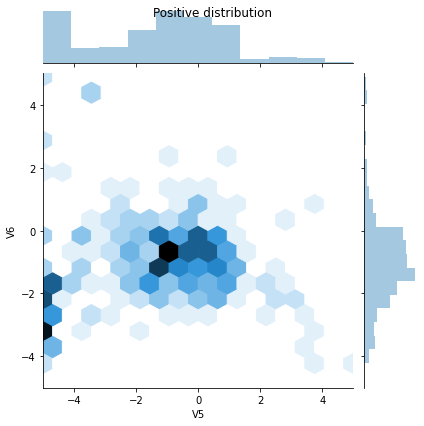

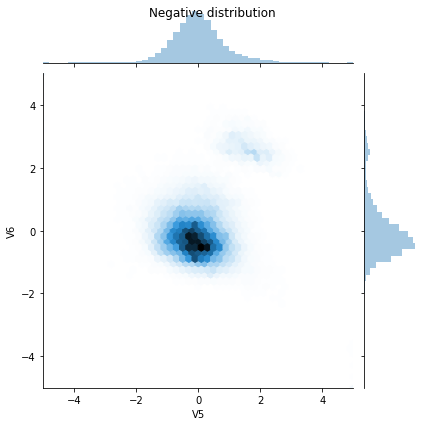

In [19]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [20]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than than a random negative sample.

Note: Accuracy is not a helpful metric for this task. You can 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

Je comprend de la derniere ligne que je peux ajouter bcp de metrique le moment de la compilation. 

Et que le truc le plus importat est que lorsque on an imbalanced data set, le accuracy ne sert pas a grand chose, car on peut avoir 99% de reussite mais preire faux tt le temps :( 

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

Si le batch size est tres petit, y'a moyen qu'il n'aura aucun transaction fauduleuse pour apprendre 

In [21]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [22]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [23]:
model.predict(train_features[:10])

array([[0.4279715 ],
       [0.70915794],
       [0.715033  ],
       [0.80995965],
       [0.66025347],
       [0.68496865],
       [0.6249493 ],
       [0.6374997 ],
       [0.5113633 ],
       [0.8199116 ]], dtype=float32)

### Optional: Set the correct initial bias.

These are initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [25]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.1393


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [26]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [27]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00013483],
       [0.00148007],
       [0.00201443],
       [0.00025684],
       [0.00183246],
       [0.00256121],
       [0.00256291],
       [0.00261465],
       [0.00133629],
       [0.00237808]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0129


This initial loss is about 50 times less than if would have been with naive initilization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [28]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [29]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [32]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [34]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

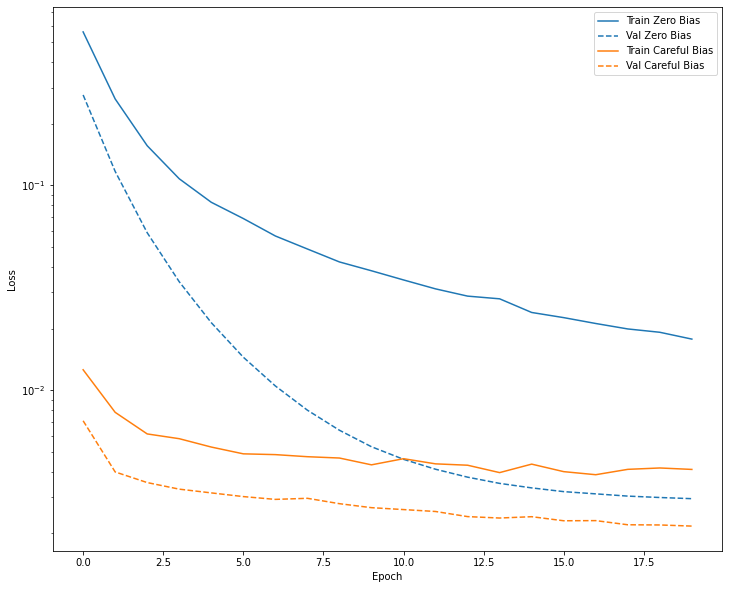

In [35]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [36]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 1s 16ms/step - loss: 0.0130 - tp: 72.0000 - fp: 45.0000 - tn: 227397.0000 - fn: 331.0000 - accuracy: 0.9983 - precision: 0.6154 - recall: 0.1787 - auc: 0.7263 - val_loss: 0.0074 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45494.0000 - val_fn: 75.0000 - val_accuracy: 0.9984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9249
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0076 - tp: 97.0000 - fp: 17.0000 - tn: 181931.0000 - fn: 231.0000 - accuracy: 0.9986 - precision: 0.8509 - recall: 0.2957 - auc: 0.8859 - val_loss: 0.0040 - val_tp: 44.0000 - val_fp: 8.0000 - val_tn: 45486.0000 - val_fn: 31.0000 - val_accuracy: 0.9991 - val_precision: 0.8462 - val_recall: 0.5867 - val_auc: 0.9528
Epoch 3/100
90/90 [==============================] - 1s 9ms/step - loss: 0.0060 - tp: 164.0000 - fp: 26.0000 - tn: 181922.0000 - fn: 164.0000 - accuracy: 0.9990 - precision: 0.8632 - recall: 0.5000 - auc:

Epoch 22/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0039 - tp: 212.0000 - fp: 25.0000 - tn: 181923.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8945 - recall: 0.6463 - auc: 0.9291 - val_loss: 0.0022 - val_tp: 64.0000 - val_fp: 9.0000 - val_tn: 45485.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.8767 - val_recall: 0.8533 - val_auc: 0.9531
Epoch 23/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0037 - tp: 215.0000 - fp: 27.0000 - tn: 181921.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8884 - recall: 0.6555 - auc: 0.9458 - val_loss: 0.0021 - val_tp: 64.0000 - val_fp: 9.0000 - val_tn: 45485.0000 - val_fn: 11.0000 - val_accuracy: 0.9996 - val_precision: 0.8767 - val_recall: 0.8533 - val_auc: 0.9531
Epoch 24/100
90/90 [==============================] - 1s 9ms/step - loss: 0.0038 - tp: 213.0000 - fp: 29.0000 - tn: 181919.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8802 - recall: 0.6494 - auc: 0.9337 -

### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [39]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

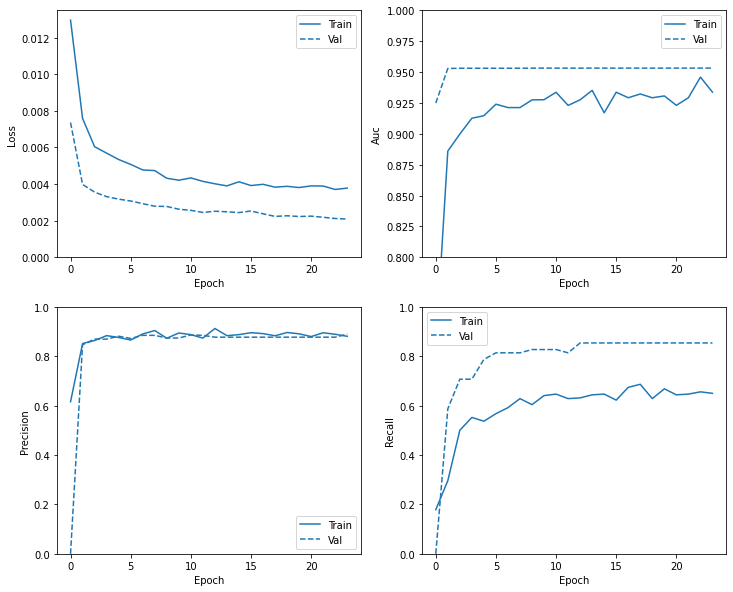

In [38]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [44]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

In [45]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

loss :  0.0038935174234211445
tp :  65.0
fp :  20.0
tn :  56853.0
fn :  24.0
accuracy :  0.9992275834083557
precision :  0.7647058963775635
recall :  0.7303370833396912
auc :  0.9153721332550049



NameError: name 'test_predictions_baseline' is not defined

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

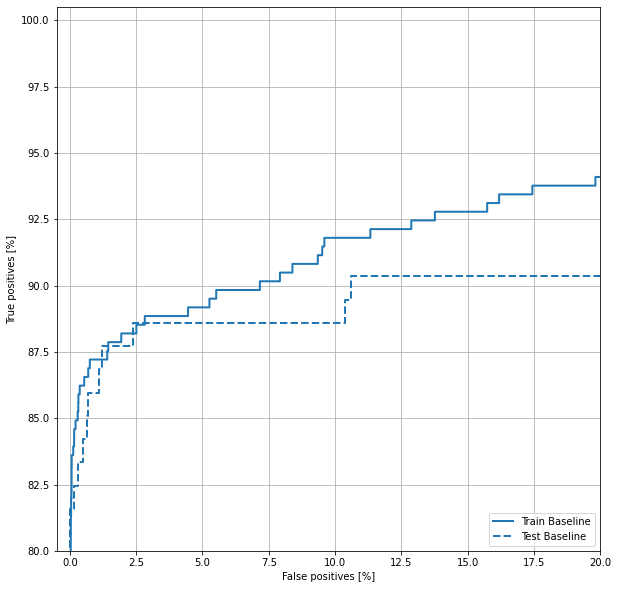

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fradulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [33]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 2s 13us/sample - loss: 1.7409 - tp: 62.0000 - fp: 76.0000 - tn: 181895.0000 - fn: 243.0000 - accuracy: 0.9982 - precision: 0.4493 - recall: 0.2033 - auc: 0.8208 - val_loss: 0.6636 - val_tp: 40.0000 - val_fp: 7.0000 - val_tn: 45489.0000 - val_fn: 33.0000 - val_accuracy: 0.9991 - val_precision: 0.8511 - val_recall: 0.5479 - val_auc: 0.9364
Epoch 2/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.7414 - tp: 171.0000 - fp: 233.0000 - tn: 181738.0000 - fn: 134.0000 - accuracy: 0.9980 - precision: 0.4233 - recall: 0.5607 - auc: 0.9201 - val_loss: 0.3944 - val_tp: 59.0000 - val_fp: 26.0000 - val_tn: 45470.0000 - val_fn: 14.0000 - val_accuracy: 0.9991 - val_precision: 0.6941 - val_recall: 0.8082 - val_auc: 0.9567
Epoch 3/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.4927 - tp:

Epoch 21/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.1956 - tp: 277.0000 - fp: 6497.0000 - tn: 175474.0000 - fn: 28.0000 - accuracy: 0.9642 - precision: 0.0409 - recall: 0.9082 - auc: 0.9748 - val_loss: 0.1384 - val_tp: 66.0000 - val_fp: 865.0000 - val_tn: 44631.0000 - val_fn: 7.0000 - val_accuracy: 0.9809 - val_precision: 0.0709 - val_recall: 0.9041 - val_auc: 0.9898
Epoch 22/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.2113 - tp: 273.0000 - fp: 6761.0000 - tn: 175210.0000 - fn: 32.0000 - accuracy: 0.9627 - precision: 0.0388 - recall: 0.8951 - auc: 0.9703 - val_loss: 0.1354 - val_tp: 66.0000 - val_fp: 882.0000 - val_tn: 44614.0000 - val_fn: 7.0000 - val_accuracy: 0.9805 - val_precision: 0.0696 - val_recall: 0.9041 - val_auc: 0.9902
Epoch 23/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.2192 - tp: 272.0000 - fp: 6567.0000 - tn: 175404.0000 - fn: 33.0000 - accuracy: 0.9638 - precision: 0.0398

### Check training history

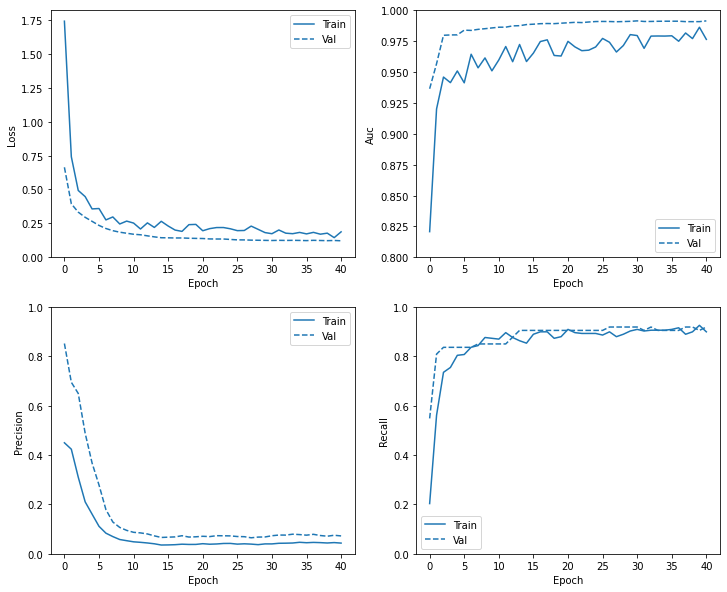

In [34]:
plot_metrics(weighted_history)

### Evaluate metrics

In [35]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07716926628907056
tp :  103.0
fp :  1040.0
tn :  55808.0
fn :  11.0
accuracy :  0.9815491
precision :  0.09011374
recall :  0.9035088
auc :  0.9790242

Legitimate Transactions Detected (True Negatives):  55808
Legitimate Transactions Incorrectly Detected (False Positives):  1040
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  103
Total Fraudulent Transactions:  114


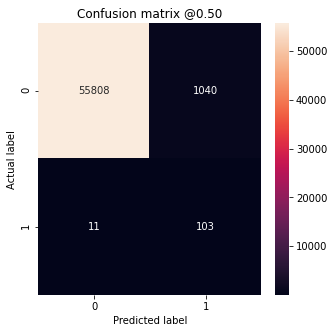

In [36]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade offs between these different types of errors for your application.

### Plot the ROC

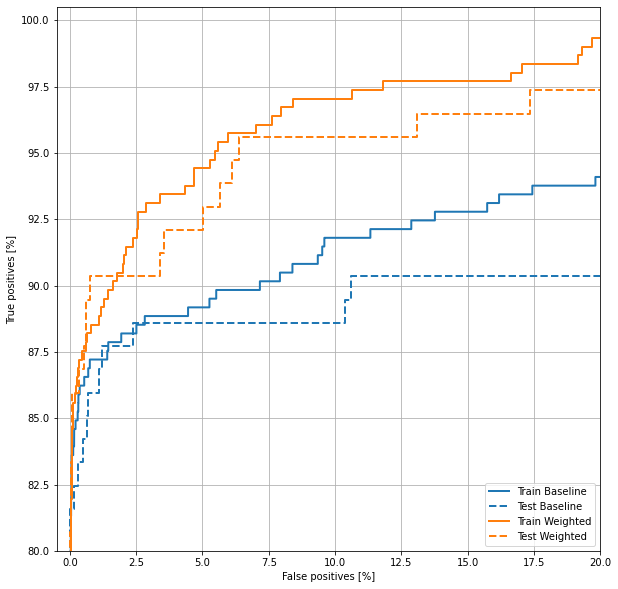

In [37]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling (le Suréchantillonnage)

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [59]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

print(f"The number of positive samples is : {len(pos_labels)}")
print(f"The number of negative samples is : {len(neg_labels)}")
print("")
print("The number of positive samples is less or equal than the number of negative samples")

The number of positive samples is : 328
The number of negative samples is : 181948

The number of positive samples is less or equal than the number of negative samples


#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [64]:
print(pos_features.shape)
print(neg_features.shape)
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))
print(choices , len(choices))
res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]
print(f"the number of features is : {len(pos_features)}")
print()
res_pos_features.shape

(328, 29)
(181948, 29)
[ 89 230  36 ...  14  23 110] 181948
the number of features is : 328



(181948, 29)

In [70]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)
print(len(resampled_features))
print(len(resampled_features)==181948*2)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
print(order, len(order))
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

363896
True
[232932 166805 129233 ... 122389  31521 220483] 363896


(363896, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [72]:
print("The number of positive samples is less or equal than the number of negative samples")

The number of positive samples is less or equal than the number of negative samples


In [74]:
print(features)

NameError: name 'features' is not defined

In [93]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [92]:
pos_ds.take(0)

<TakeDataset shapes: ((29,), ()), types: (tf.float64, tf.int64)>

Each dataset provides `(feature, label)` pairs:

In [96]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy(), len(features))
  print()
  print("Label: ", label.numpy()) 

Features:
 [ 0.43710632  2.46371712 -4.91697147  5.          0.71629931 -2.06375222
 -1.23726089  0.45389434 -2.14211952 -3.62208425  5.         -5.
  0.7561791  -5.         -0.70971908 -1.22481894  1.80324194  2.18360889
 -0.10944514  0.62252978  0.51357874  0.20024924  0.38164267 -0.39037678
 -1.92714951  0.90413873  1.54608731  0.43886803 -1.45523726] 29

Label:  1


In [101]:
for features, label in neg_ds.take(1):
  print("Features:\n", features.numpy(), len(features))
  print()
  print("Label: ", label.numpy()) 

Features:
 [ 0.65131022 -0.85048602  0.23559206 -0.99539883 -1.04079919 -0.09798227
 -0.84729462 -0.0241445  -1.55314061  1.2164968  -0.65537195 -0.98043582
  0.5041362  -0.34573509  1.16806271 -0.35893883  0.62968324 -0.39767562
 -0.54585803 -0.15513562 -0.41707326 -1.04322433  0.07633653 -0.7997859
  0.15187397 -0.74799071  0.09419775  0.11780987  0.93284418] 29

Label:  0


Merge the two together using `experimental.sample_from_datasets`:

In [78]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [83]:
resampled_ds

<PrefetchDataset shapes: ((None, 29), (None,)), types: (tf.float64, tf.int64)>

In [99]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean(), len(features), len(label))
    print(features)
    print(label)

0.4755859375 2048 2048
tf.Tensor(
[[-0.52992243  0.38285885  0.46491968 ... -0.34151433 -0.0539513
   0.41744281]
 [ 0.65177905  0.27998748 -0.33227446 ... -0.11365879  0.09400976
  -1.59078035]
 [ 0.70489307 -0.24883206 -0.05584429 ... -0.19814611 -0.03379516
  -0.08723446]
 ...
 [ 0.61513044  0.24019013  0.41418129 ...  0.07149795  0.08928972
  -0.550299  ]
 [ 0.05026361  0.68587759  0.23960992 ...  0.41222913  0.00521102
  -0.77137303]
 [-1.24107409  1.94148983 -4.36898659 ...  1.05087405 -0.97779271
   1.45822478]], shape=(2048, 29), dtype=float64)
tf.Tensor([0 0 0 ... 0 0 1], shape=(2048,), dtype=int64)


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [110]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [46]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Train for 278.0 steps, validate for 23 steps
Epoch 1/100
278/278 [==============================] - 9s 32ms/step - loss: 0.3914 - tp: 251412.0000 - fp: 76514.0000 - tn: 208189.0000 - fn: 33229.0000 - accuracy: 0.8072 - precision: 0.7667 - recall: 0.8833 - auc: 0.9166 - val_loss: 0.2670 - val_tp: 64.0000 - val_fp: 953.0000 - val_tn: 44543.0000 - val_fn: 9.0000 - val_accuracy: 0.9789 - val_precision: 0.0629 - val_recall: 0.8767 - val_auc: 0.9691
Epoch 2/100
278/278 [==============================] - 7s 23ms/step - loss: 0.2172 - tp: 256995.0000 - fp: 15291.0000 - tn: 269297.0000 - fn: 27761.0000 - accuracy: 0.9244 - precision: 0.9438 - recall: 0.9025 - auc: 0.9687 - val_loss: 0.1323 - val_tp: 65.0000 - val_fp: 806.0000 - val_tn: 44690.0000 - val_fn: 8.0000 - val_accuracy: 0.9821 - val_precision: 0.0746 - val_recall: 0.8904 - val_auc: 0.9870
Epoch 3/100
278/278 [==============================] - 7s 24ms/step - loss: 0.1629 - tp: 260265.0000 - fp: 10518.0000 - tn: 274478.0000 - fn: 24083.0

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, **the oversampled data provides a smoother gradient signal** : Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

**This smoother gradient signal makes it easier to train the model**.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

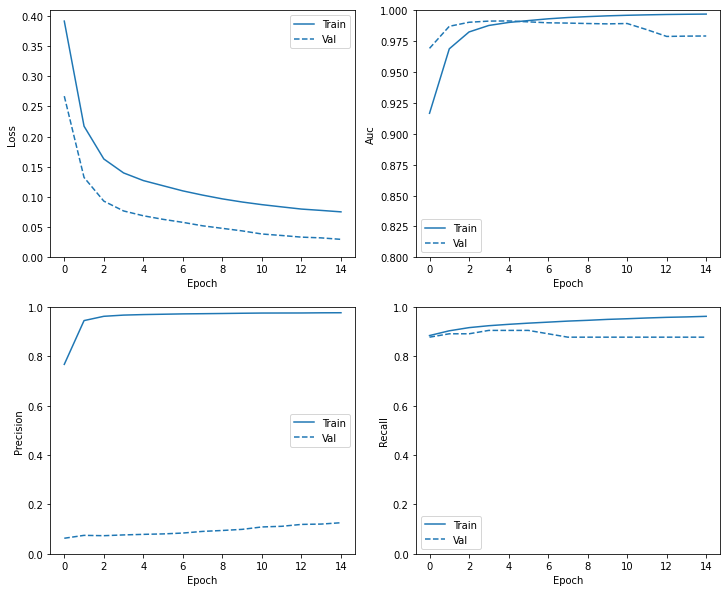

In [47]:
plot_metrics(resampled_history )

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [48]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Train for 20 steps, validate for 23 steps
Epoch 1/1000
20/20 [==============================] - 2s 125ms/step - loss: 0.7476 - tp: 14251.0000 - fp: 11410.0000 - tn: 9061.0000 - fn: 6238.0000 - accuracy: 0.5691 - precision: 0.5554 - recall: 0.6955 - auc: 0.6657 - val_loss: 0.7225 - val_tp: 68.0000 - val_fp: 23927.0000 - val_tn: 21569.0000 - val_fn: 5.0000 - val_accuracy: 0.4748 - val_precision: 0.0028 - val_recall: 0.9315 - val_auc: 0.9223
Epoch 2/1000
20/20 [==============================] - 0s 19ms/step - loss: 0.5403 - tp: 17819.0000 - fp: 10908.0000 - tn: 9601.0000 - fn: 2632.0000 - accuracy: 0.6694 - precision: 0.6203 - recall: 0.8713 - auc: 0.8479 - val_loss: 0.6741 - val_tp: 67.0000 - val_fp: 20133.0000 - val_tn: 25363.0000 - val_fn: 6.0000 - val_accuracy: 0.5581 - val_precision: 0.0033 - val_recall: 0.9178 - val_auc: 0.9309
Epoch 3/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.4759 - tp: 18479.0000 - fp: 9616.0000 - tn: 10849.0000 - fn: 2016.0000 - accurac

Epoch 42/1000
20/20 [==============================] - 0s 23ms/step - loss: 0.1465 - tp: 18760.0000 - fp: 696.0000 - tn: 19801.0000 - fn: 1703.0000 - accuracy: 0.9414 - precision: 0.9642 - recall: 0.9168 - auc: 0.9864 - val_loss: 0.0859 - val_tp: 66.0000 - val_fp: 755.0000 - val_tn: 44741.0000 - val_fn: 7.0000 - val_accuracy: 0.9833 - val_precision: 0.0804 - val_recall: 0.9041 - val_auc: 0.9911
Epoch 43/1000
20/20 [==============================] - 0s 22ms/step - loss: 0.1425 - tp: 18653.0000 - fp: 652.0000 - tn: 20051.0000 - fn: 1604.0000 - accuracy: 0.9449 - precision: 0.9662 - recall: 0.9208 - auc: 0.9869 - val_loss: 0.0842 - val_tp: 66.0000 - val_fp: 752.0000 - val_tn: 44744.0000 - val_fn: 7.0000 - val_accuracy: 0.9833 - val_precision: 0.0807 - val_recall: 0.9041 - val_auc: 0.9911
Epoch 44/1000
20/20 [==============================] - 0s 23ms/step - loss: 0.1423 - tp: 18717.0000 - fp: 657.0000 - tn: 19926.0000 - fn: 1660.0000 - accuracy: 0.9434 - precision: 0.9661 - recall: 0.9185 

### Re-check training history

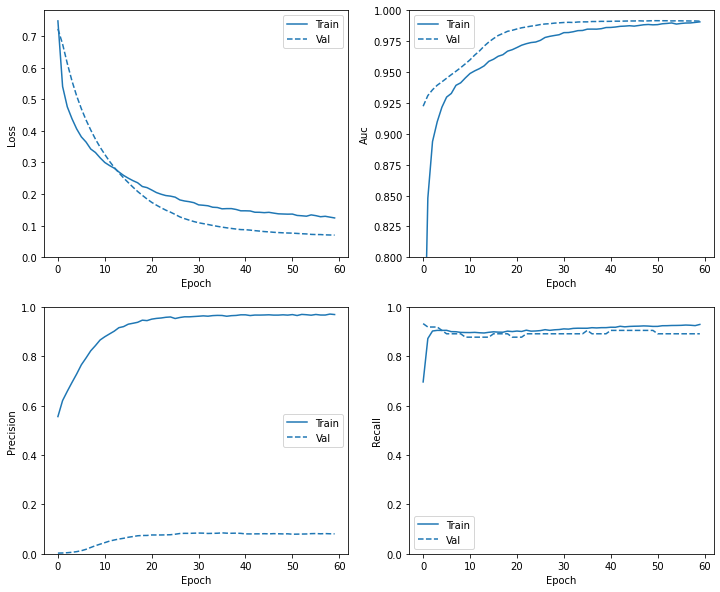

In [49]:
plot_metrics(resampled_history)

### Evaluate metrics

In [50]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07649654533250634
tp :  104.0
fp :  946.0
tn :  55902.0
fn :  10.0
accuracy :  0.9832169
precision :  0.099047616
recall :  0.9122807
auc :  0.97800624

Legitimate Transactions Detected (True Negatives):  55902
Legitimate Transactions Incorrectly Detected (False Positives):  946
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  104
Total Fraudulent Transactions:  114


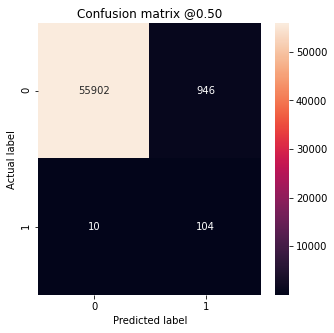

In [51]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

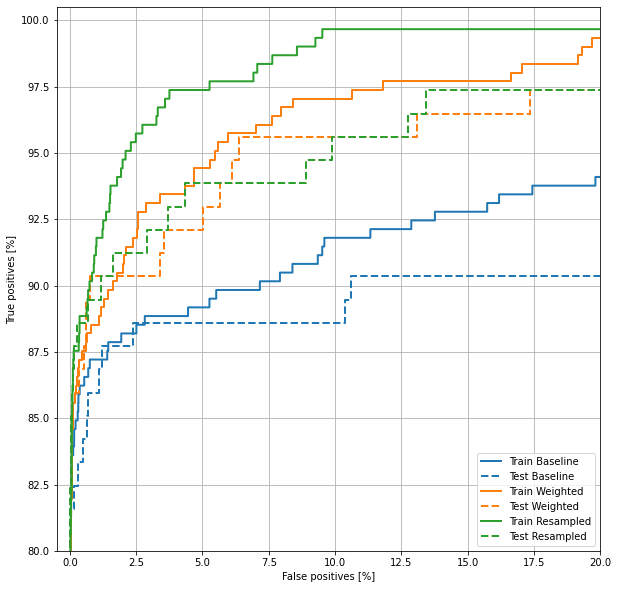

In [52]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

## Applying this tutorial to your problem

Imbalanced data classification is an inherantly difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.